# [NTDS'18] Final Project: Senator vote predictions based on graph features

## Students

* Team: `7`
* Students: `Mathias Gonçalves Julien Heitmann Mathieu Lamiot Louis Landell`
* Dataset: `US Senators`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

#Import json to retrieve the data
import json
#Import requests to send CURL requests to the API. This needs to be installed beforehand
import requests
#Import distances
from scipy.spatial.distance import pdist, squareform

from scipy import sparse
import scipy.sparse.linalg

from sklearn.linear_model import LogisticRegression
from pyunlocbox import functions, solvers
import networkx as nx

## 1 - Loading the data

All the data we load here was retrieved in the first milestone thanks to the dedicated API. Using this API takes some times, hence it is not repeated here and we simply load previously saved files.

* "votes_results_matrix" is a dataframe containing the vote of each senator for each law.
* "DFvotes" is a dataframe containing the features of each vote: who introduced it, which committee, results,...


In [2]:
#Load the vote results by senators
votes_results_matrix = pd.read_csv('features.csv')
#Remove extra column due to csv format
del votes_results_matrix['Unnamed: 0']
#Change labels to 1/-1
votes_results_matrix = votes_results_matrix.replace(0,-1)
#Display
votes_results_matrix

,C115S2C244,C115S2C243,C115S2C242,C115S2C241,C115S2C240,C115S2C239,C115S2C238,C115S2C237,C115S2C236,C115S2C235,...,C111S2C37,C111S2C36,C111S2C35,C111S2C34,C111S2C33,C111S2C32,C111S2C31,C111S2C30,C111S2C29,C111S2C28
0,1.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.0,-1.0,-1.0,1,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,1.0,1,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1.0,1.0,-1.0,1,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-1.0,-1.0,-1.0,1,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,-1.0,1.0,-1.0,1,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#Load the data of each vote (sponsor, results, etc.)
DFvotes = pd.read_pickle('DFvotes.pkl')
#Display
DFvotes

,amendment.api_uri,amendment.number,amendment.sponsor,amendment.sponsor_id,amendment.sponsor_party,amendment.sponsor_state,amendment.sponsor_uri,bill.api_uri,bill.bill_id,bill.bill_uri,...,question,result,roll_call,session,time,total.no,total.not_voting,total.present,total.yes,vote_uri
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pn1860-115,NaN,...,On the Nomination,Nomination Confirmed,244,2,13:47:00,34,2,0,64,https://api.propublica.org/congress/v1/115/sen...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sjres65-115,https://api.propublica.org/congress/v1/115/bil...,...,On the Motion to Table,Motion to Table Agreed to,243,2,12:25:00,21,2,0,77,https://api.propublica.org/congress/v1/115/sen...
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pn1860-115,NaN,...,On the Cloture Motion,Cloture Motion Agreed to,242,2,14:48:00,36,1,0,63,https://api.propublica.org/congress/v1/115/sen...
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,s140-115,https://api.propublica.org/congress/v1/115/bil...,...,On the Motion,Motion Agreed to,241,2,14:21:00,6,0,0,94,https://api.propublica.org/congress/v1/115/sen...
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,s140-115,https://api.propublica.org/congress/v1/115/bil...,...,On the Cloture Motion,Cloture Motion Agreed to,240,2,17:31:00,5,2,0,93,https://api.propublica.org/congress/v1/115/sen...
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pn1644-115,NaN,...,On the Nomination,Nomination Confirmed,239,2,19:01:00,30,5,0,65,https://api.propublica.org/congress/v1/115/sen...
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pn1421-115,NaN,...,On the Nomination,Nomination Confirmed,238,2,18:48:00,43,5,0,52,https://api.propublica.org/congress/v1/115/sen...
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pn1419-115,NaN,...,On the Nomination,Nomination Confirmed,237,2,18:34:00,44,5,0,51,https://api.propublica.org/congress/v1/115/sen...
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pn1415-115,NaN,...,On the Nomination,Nomination Confirmed,236,2,18:19:00,41,5,0,54,https://api.propublica.org/congress/v1/115/sen...
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pn1406-115,NaN,...,On the Nomination,Nomination Confirmed,235,2,18:03:00,40,5,0,55,https://api.propublica.org/congress/v1/115/sen...


## 1 - First Feature: 2nd Laplacian eigenvector

In the following, we summarize what we found out during milestone 3. Laplacian eigenmaps of the network based on the votes of each senators provides a nice way of clustering senators that can be interpreted as their party. As we will see, it provides a powerful feature for our classifier as it already achieves good performances with only one feature coming from the 2nd dimension of the Laplacian eigenmaps.

First, let's review the graph we will use in this section. Each node is a senator and edges/weights are generated from 'votes_results_matrix': for each pair of senator, we computed a distance based on their votes in common (cf. milestone 1). The graph we obtained is the presented below. It is strongly clustered into two parts, that are actually the parties (democrats and republicans).

C:\Users\agadg\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


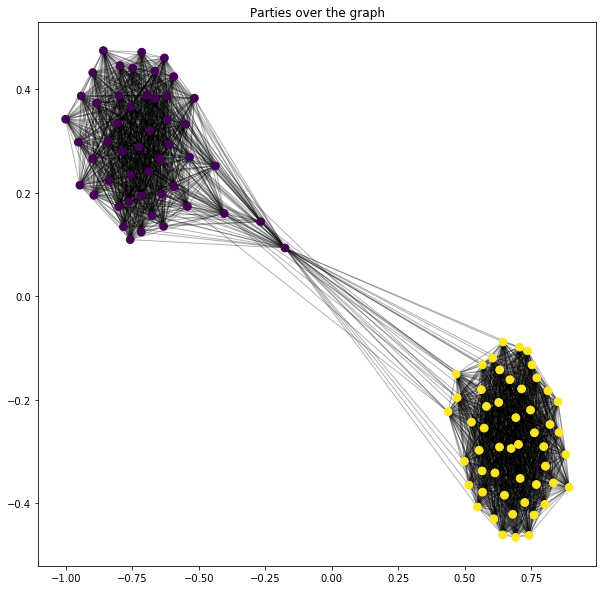

In [4]:
#Load the graph
adjacency = np.load("adjacencyV2.npy")
# Load party affiliation list
party = np.load("party.npy")
party_for_graph = (((party == 'R')*1)-0.5)*2

#Display the graph and the parties
graph = nx.from_scipy_sparse_matrix(scipy.sparse.csr_matrix(adjacency))
coords = nx.spring_layout(graph)  # Force-directed layout.
plt.figure(figsize= (10,10))
plt.subplot(111)
plt.title("Parties over the graph")
nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=party_for_graph)
nx.draw_networkx_edges(graph, coords, alpha=0.3)

Even if Republicans/Democrats could be a good feature to begin with, it seems that some senators are strongly coherent with their party whereas some other are a bit "in-between". Hence, a binary feature might not capture exactly the phenomenon.

In order to get a good measure of affiliation with the party, we will have a deeper look into the laplacian eigenmaps, as suggested in milestone 3.

In [5]:
# Create the Laplacian
degree_vect = np.sum(adjacency,axis=1)
degree_matrix = np.diag(degree_vect)
laplacian = degree_matrix-adjacency
laplacian_csr = sparse.csr_matrix(laplacian)
# Compute eigenvectors using sparse laplacian - Missing the last eigenvalue
d = 8
eig_val, eig_vect = sparse.linalg.eigsh(laplacian_csr, k=d, which = 'SM')

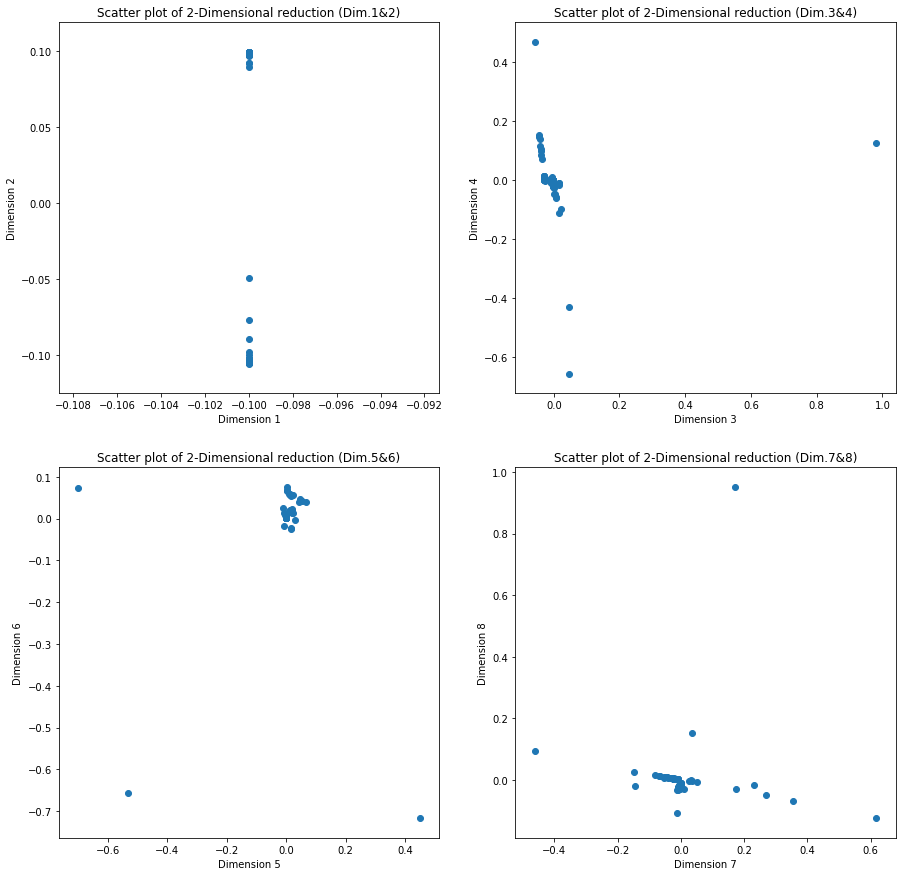

In [6]:
plt.figure(figsize= (15,15))
plt.subplot(221)
plt.scatter(eig_vect[:,0], eig_vect[:,1])
plt.title("Scatter plot of 2-Dimensional reduction (Dim.1&2)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")


plt.subplot(222)
plt.scatter(eig_vect[:,2], eig_vect[:,3])
plt.title("Scatter plot of 2-Dimensional reduction (Dim.3&4)")
plt.xlabel("Dimension 3")
plt.ylabel("Dimension 4")

plt.subplot(223)
plt.scatter(eig_vect[:,4], eig_vect[:,5])
plt.title("Scatter plot of 2-Dimensional reduction (Dim.5&6)")
plt.xlabel("Dimension 5")
plt.ylabel("Dimension 6")

plt.subplot(224)
plt.scatter(eig_vect[:,6], eig_vect[:,7])
plt.title("Scatter plot of 2-Dimensional reduction (Dim.7&8)")
plt.xlabel("Dimension 7")
plt.ylabel("Dimension 8")
plt.show()

As we can see, the dimensions 2, 4 and 7 seem to be the most relevant to separate the senators. Other dimensions lead to the separation of one (or a couple) of senators only which means they are likely not to be useful. Let's see if those three dimensions are actually useful.
We add to the following plots colors depending on the party of each senator (republicans and democrats) to try and interpret those dimensions.

Text(0, 0.5, 'Dimension 7')

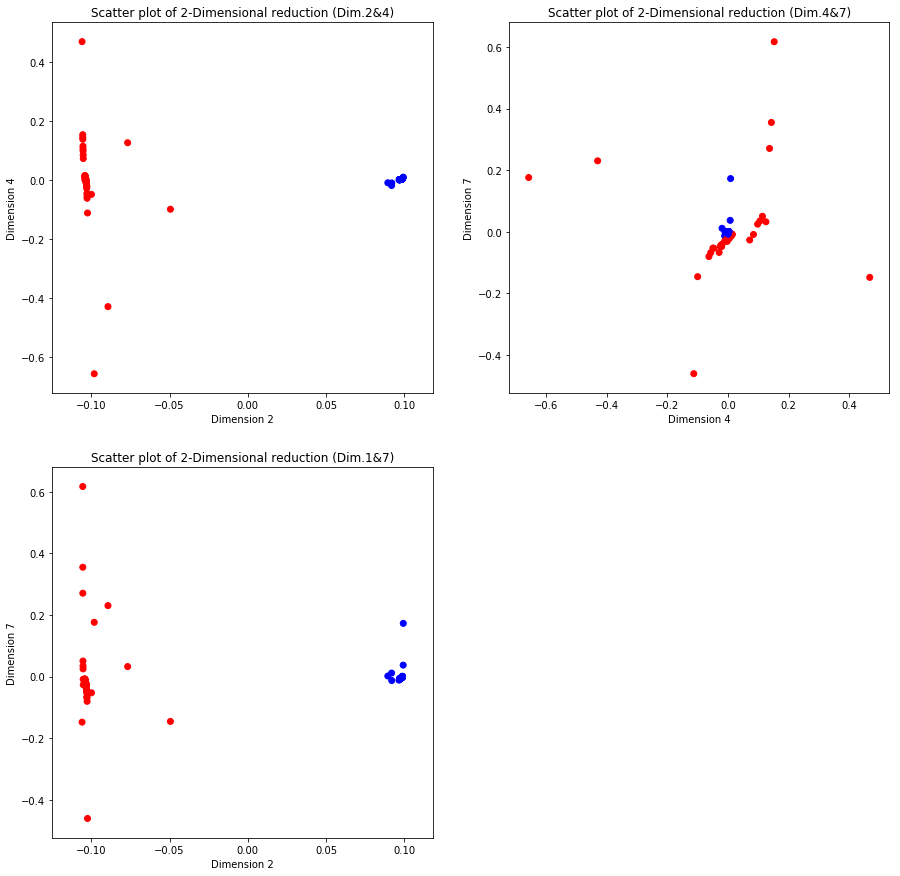

In [7]:
#Generate a colormap based on the party of each senator
color_map = np.repeat('r', party.size)
color_map[party == 'R'] = 'b'


plt.figure(figsize= (15,15))
plt.subplot(221)
plt.scatter(eig_vect[:,1], eig_vect[:,3],c=color_map)
plt.title("Scatter plot of 2-Dimensional reduction (Dim.2&4)")
plt.xlabel("Dimension 2")
plt.ylabel("Dimension 4")


plt.subplot(222)
plt.scatter(eig_vect[:,3], eig_vect[:,6],c=color_map)
plt.title("Scatter plot of 2-Dimensional reduction (Dim.4&7)")
plt.xlabel("Dimension 4")
plt.ylabel("Dimension 7")


plt.subplot(223)
plt.scatter(eig_vect[:,1], eig_vect[:,6],c=color_map)
plt.title("Scatter plot of 2-Dimensional reduction (Dim.1&7)")
plt.xlabel("Dimension 2")
plt.ylabel("Dimension 7")

Dimensions 4 and 7 seem to seperate only a few senators from the others, hence they are probably not a useful general feature. Notice that dimension 2 is strongly linked to the party of the senator and separate republicans from democrats. Hence, this dimension is particularly interesting as it can be easily interpreted. No specific interpretations were found for the other dimensions.
Thanks to this observation, we will use dimension 2 as a feature for our classifier: As each vote is introduced by a person affiliated to a party, our feature will be the distance of a senator to the party linked to the vote (Republican = 0.1, Democrats = -0.1) along that 2nd dimension of the eigenmaps.

In [8]:
def feature_laplacian_eigen_dim2(senatorID,voteID):
    
    #Retrieve the feature of the senator
    senatorLoc = eig_vect[senatorID,1]
    
    #Retrieve the feature of the vote
    vote = DFvotes[DFvotes['id']== voteID]
    voteParty = list(vote['amendment.sponsor_party'])
    if voteParty[0] == 'D':
        voteLoc = -0.1
        #print("D")
    elif voteParty[0] == 'R':
        voteLoc = 0.1
        #print("R")
    else:
        voteLoc = senatorLoc #In this case, we want the feature not to count
    
    #Compute the distance between the two features to be used as a new feature
    distance = (voteLoc-senatorLoc)
    return distance 


## N - Preparing the lables & features

In [9]:
#Generate a list of labels and features to be used by the linear classifier
labels = []
features= []
for col in votes_results_matrix:
    column = votes_results_matrix[col]
    for senatorID in range(0,100):
        #If this vote actually happened
        if not(np.isnan(column[senatorID])):
            labels.append(column[senatorID])
            
            #Retrieve all the features for that vote/senator sample
            #Feature structure : laplacian_eigen_dim2 (party), ...
            feature = []
            feature.append(feature_laplacian_eigen_dim2(senatorID,col))
            #feature.append( "une nouvelle feature" )
            #...
            
            #Append to the global features list
            features.append(feature)
features = np.asarray(features)

In [10]:
labels

[1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,


In [11]:
features

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

## N+1 - The classifier

As using a classifier is not at the core of this course, we decided to go for a simple, off-the-shelf linear classifier : [Logistic Regression, from the sklearn package](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression).
One sample is a senator voting in favor of/against a law. 


In [16]:
#Fit the classifier to the data
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(np.asarray(features), labels)

In [17]:
#Compute the percentage of good classifications
score = clf.score(np.asarray(features), labels)
print("Classifier score : " + str(score))


Classifier score : 0.6809497012085645
